In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot as plt 
import sklearn
from sklearn.model_selection import train_test_split

## IMPORT & EXPLORE

In [10]:
lung_scans = np.load(r"C:\Users\User\Desktop\pneumonia_detection_project\data\arrays\pneumonia_detection_ext.npz")['images']
lung_scans_labels = np.load(r"C:\Users\User\Desktop\pneumonia_detection_project\data\arrays\pneumonia_detection_ext.npz")['labels']

#### FUNCTIONS

In [ ]:
def generate_augmented_images(images, labels, augmentations_per_image=3, zoom_range=(0.9, 1.3)):
    augmented_images = []
    augmented_labels = []

    # Precompute random values for efficiency
    num_total_augs = len(images) * augmentations_per_image
    random_flips_lr = tf.random.uniform([num_total_augs], 0, 2, dtype=tf.int32)
    random_flips_ud = tf.random.uniform([num_total_augs], 0, 2, dtype=tf.int32)
    random_rotations = tf.random.uniform([num_total_augs], 0, 4, dtype=tf.int32)
    random_brightness = tf.random.uniform([num_total_augs], -0.1, 0.1)
    random_contrasts = tf.random.uniform([num_total_augs], 0.8, 1.2)
    zoom_factors = tf.random.uniform([num_total_augs], zoom_range[0], zoom_range[1])

    # Process images
    aug_idx = 0
    for img, lbl in zip(images, labels):
        # Ensure image is properly shaped for grayscale (h, w, 1)
        if len(img.shape) == 2:
            img = tf.expand_dims(img, axis=-1)

        # Safety check: ensure values are within range [0, 1]
        img = tf.clip_by_value(img, 0.0, 1.0)

        h, w, c = img.shape

        for _ in range(augmentations_per_image):
            # Start with a clean copy of the image
            aug_img = tf.identity(img)

            # Apply random horizontal flip
            if random_flips_lr[aug_idx] > 0:
                aug_img = tf.image.flip_left_right(aug_img)

            # Apply random vertical flip
            if random_flips_ud[aug_idx] > 0:
                aug_img = tf.image.flip_up_down(aug_img)

            # Apply random rotation (90-degree increments)
            aug_img = tf.image.rot90(aug_img, k=random_rotations[aug_idx])

            # Apply random brightness with safety check
            aug_img = tf.image.adjust_brightness(aug_img, random_brightness[aug_idx])
            aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Apply random contrast with safety check
            aug_img = tf.image.adjust_contrast(aug_img, random_contrasts[aug_idx])
            aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Gaussian noise - optimized for grayscale
            if tf.random.uniform(()) > 0.7:  # Apply with 30% probability
                noise = tf.random.normal(shape=tf.shape(aug_img), mean=0.0, stddev=0.05)
                aug_img = tf.clip_by_value(aug_img + noise, 0.0, 1.0)

            # Random zoom with more robust logic
            zoom_factor = zoom_factors[aug_idx]

            try:
                if zoom_factor > 1.0:  # Zoom in
                    # Ensure new dimensions are at least 1
                    new_h = tf.maximum(tf.cast(h / zoom_factor, tf.int32), 1)
                    new_w = tf.maximum(tf.cast(w / zoom_factor, tf.int32), 1)

                    # Calculate crop position
                    top = (h - new_h) // 2
                    left = (w - new_w) // 2

                    # Ensure valid crop boundaries
                    if new_h > 0 and new_w > 0 and top >= 0 and left >= 0:
                        aug_img = tf.image.crop_to_bounding_box(aug_img, top, left, new_h, new_w)
                        aug_img = tf.image.resize(aug_img, (h, w))
                else:  # Zoom out
                    # Ensure new dimensions don't exceed int32 max
                    new_h = tf.minimum(tf.cast(h * zoom_factor, tf.int32), tf.int32.max)
                    new_w = tf.minimum(tf.cast(w * zoom_factor, tf.int32), tf.int32.max)

                    # Ensure dimensions are at least 1
                    new_h = tf.maximum(new_h, 1)
                    new_w = tf.maximum(new_w, 1)

                    aug_img = tf.image.resize(aug_img, (new_h, new_w))
                    aug_img = tf.image.resize_with_crop_or_pad(aug_img, h, w)
            except tf.errors.InvalidArgumentError:
                # If zoom causes error, skip this transformation
                pass

            # Random gamma adjustment with safety check
            if tf.random.uniform(()) > 0.7:
                gamma = tf.random.uniform([], 0.8, 1.2)
                aug_img = tf.image.adjust_gamma(aug_img, gamma)
                aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Random cutout (masking) - safer version
            if tf.random.uniform(()) > 0.8:  # Apply with 20% probability
                mask_size_h = tf.maximum(tf.cast(h * tf.random.uniform([], 0.1, 0.2), tf.int32), 1)
                mask_size_w = tf.maximum(tf.cast(w * tf.random.uniform([], 0.1, 0.2), tf.int32), 1)

                # Ensure mask position is valid
                mask_y = tf.minimum(tf.random.uniform([], 0, h - mask_size_h, dtype=tf.int32), h - 1)
                mask_x = tf.minimum(tf.random.uniform([], 0, w - mask_size_w, dtype=tf.int32), w - 1)

                # Create mask
                mask = tf.zeros([mask_size_h, mask_size_w, 1]) + 0.5  # Gray mask
                paddings = [[mask_y, h - mask_y - mask_size_h],
                           [mask_x, w - mask_x - mask_size_w],
                           [0, 0]]

                # Ensure paddings are valid
                paddings = tf.maximum(paddings, 0)

                mask = tf.pad(mask, paddings)
                mask = tf.cast(mask > 0, aug_img.dtype)
                aug_img = aug_img * (1 - mask) + mask * 0.5

            # Final safety check
            aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Check for NaN values and replace with safe values
            aug_img = tf.where(tf.math.is_nan(aug_img), tf.zeros_like(aug_img), aug_img)

            # Append the augmented image
            augmented_images.append(aug_img.numpy())
            augmented_labels.append(lbl)
            aug_idx += 1

    return np.array(augmented_images), np.array(augmented_labels)

Here , i applied the same changed augmentation function as in case when dealing with tuberculosis 

In [6]:
def display_examples(images, labels, num_examples=5):
    plt.figure(figsize=(10, 10))
    
    for i in range(num_examples):
        ax = plt.subplot(1, num_examples, i + 1)
        ax.imshow(images[i])  # Display the image
        ax.set_title(f"Label: {labels[i]}")  # Display the label
        ax.axis("off")  # Hide axes
    
    plt.show()

In [ ]:
# Define subsample size (e.g., 50% of the data)
subsample_fraction = 0.5  # Adjust based on available resources

# Randomly select indices
subsample_indices = np.random.choice(len(lung_scans),
                                     size=int(len(lung_scans) * subsample_fraction),
                                     replace=False)

# Subsample images and labels
lung_scans_subsampled = lung_scans[subsample_indices]
lung_scans_labels_subsampled = lung_scans_labels[subsample_indices]


In [ ]:
lung_scans , lung_scans_labels = generate_augmented_images( images = lung_scans_subsampled ,
                                                            labels = lung_scans_labels_subsampled ,
                                                            augmentations_per_image = 2)


# 0.5 subsample used because of a computantional limits

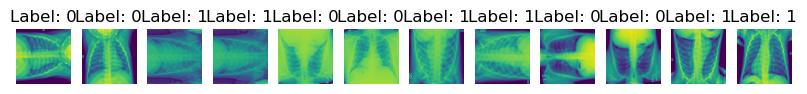

In [12]:
display_examples(images = lung_scans, 
                 labels = lung_scans_labels, 
                 num_examples=12)

In [13]:
lung_scans.shape

(16018, 224, 224, 1)

## CLEAN & PREPARE

#### PREPARE DATA FOR MODEL BUILDING

In [16]:
lung_scans_train , lung_scans_test , lung_scans_labels_train , lung_scans_labels_test =  train_test_split(
    lung_scans ,
    lung_scans_labels ,
    train_size = 0.95 ,
    stratify = lung_scans_labels ,
    random_state = 42
)

lung_scans_train , lung_scans_validation , lung_scans_labels_train , lung_scans_labels_validation  =  train_test_split(
    lung_scans_train ,
    lung_scans_labels_train ,
    train_size = 0.95 ,
    stratify = lung_scans_labels_train ,
    random_state = 42
)

In [17]:
print(f'IMAGE ARRAYS SHAPES (TRA`IN - TEST - VALIDATION) : {lung_scans_train.shape , lung_scans_test.shape , lung_scans_validation.shape }')

IMAGE ARRAYS SHAPES (TRA`IN - TEST - VALIDATION) : ((14456, 224, 224, 1), (801, 224, 224, 1), (761, 224, 224, 1))


## MODEL BUILD

In [18]:
from tensorflow.keras import models , layers , optimizers , losses , callbacks 

#### STRUCTURE

In [19]:
lung_scans_sequential_neural_net = models.Sequential( [
   
    layers.Conv2D( filters = 32 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D( filters = 64 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization(),

    layers.Conv2D( filters = 128 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization(),

    layers.Conv2D( filters = 256 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization()
    
] )

In [20]:
lung_scans_sequential_neural_net.add( layers.GlobalAveragePooling2D() )

lung_scans_sequential_neural_net.add( layers.Dense( units = 128 ,
                                                    activation = 'relu') )

lung_scans_sequential_neural_net.add( layers.Dropout(rate = 0.5) ) ,

lung_scans_sequential_neural_net.add( layers.Dense( units = 256 ,
                                                    activation = 'relu') ) 

lung_scans_sequential_neural_net.add( layers.Dense( units = 1 ,
                                                    activation = 'sigmoid') )

In [21]:
lung_scans_sequential_neural_net.build( input_shape = (lung_scans.shape) ) 

In [22]:
lung_scans_sequential_neural_net.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (16018, 222, 222, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (16018, 111, 111, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (16018, 111, 111, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (16018, 109, 109, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (16018, 54, 54, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (16018, 54, 54, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (16018, 52, 52, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (16018, 26, 26, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (16018, 26, 26, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (16018, 24, 24, 256)        │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (16018, 12, 12, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (16018, 12, 12, 256)        │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (16018, 256)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (16018, 128)                │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (16018, 128)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (16018, 256)                │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (16018, 1)                  │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 455,937 (1.74 MB)

 Trainable params: 454,977 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

#### COMPILE

In [23]:
lung_scans_sequential_neural_net.compile( optimizer = optimizers.Adam() ,
                                          loss = losses.BinaryCrossentropy(),
                                          metrics = ['accuracy'] )

lung_scans_sequential_neural_net_early_stop = callbacks.EarlyStopping( monitor = 'val_loss',
                                                                       patience = 25 ,
                                                                       restore_best_weights = True )

#### TRAIN

In [24]:
training_history = lung_scans_sequential_neural_net.fit( lung_scans_train ,
                                                         lung_scans_labels_train,
                                                         validation_data = [lung_scans_validation,lung_scans_labels_validation],
                                                         epochs = 120,  
                                                         callbacks = [lung_scans_sequential_neural_net_early_stop],
                                                         batch_size = 32 ,
                                                         verbose  = 1 )

Epoch 1/120
452/452 ━━━━━━━━━━━━━━━━━━━━ 280s 610ms/step - accuracy: 0.7000 - loss: 0.5841 - val_accuracy: 0.6899 - val_loss: 0.6912
Epoch 2/120
452/452 ━━━━━━━━━━━━━━━━━━━━ 274s 605ms/step - accuracy: 0.8348 - loss: 0.3943 - val_accuracy: 0.4639 - val_loss: 1.6543
Epoch 3/120
452/452 ━━━━━━━━━━━━━━━━━━━━ 286s 632ms/step - accuracy: 0.8832 - loss: 0.3029 - val_accuracy: 0.8042 - val_loss: 0.4298
Epoch 4/120
452/452 ━━━━━━━━━━━━━━━━━━━━ 277s 613ms/step - accuracy: 0.9056 - loss: 0.2521 - val_accuracy: 0.7832 - val_loss: 0.4659
Epoch 5/120
452/452 ━━━━━━━━━━━━━━━━━━━━ 181s 399ms/step - accuracy: 0.9211 - loss: 0.2227 - val_accuracy: 0.6347 - val_loss: 0.6316
Epoch 6/120
452/452 ━━━━━━━━━━━━━━━━━━━━ 179s 395ms/step - accuracy: 0.9293 - loss: 0.1972 - val_accuracy: 0.8607 - val_loss: 0.3380
Epoch 7/120
452/452 ━━━━━━━━━━━━━━━━━━━━ 179s 396ms/step - accuracy: 0.9272 - loss: 0.1999 - val_accuracy: 0.6360 - val_loss: 0.7617
Epoch 8/120
452/452 ━━━━━━━━━━━━━━━━━━━━ 179s 396ms/step - accuracy: 

#### EVALUATE

In [25]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       356
           1       0.93      0.94      0.93       445

    accuracy                           0.93       801
   macro avg       0.93      0.92      0.93       801
weighted avg       0.93      0.93      0.93       801



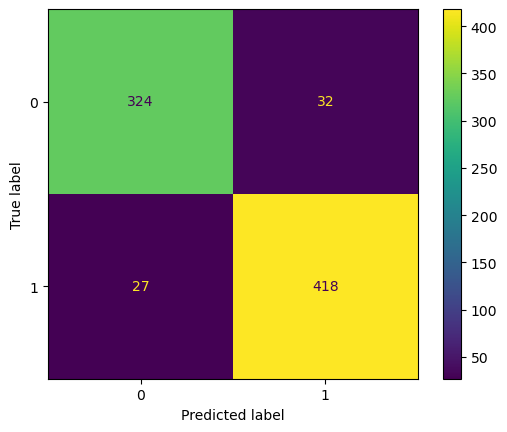

In [26]:
# Convert probabilities to class labels using a threshold of 0.5
predicted_labels = (lung_scans_sequential_neural_net.predict(lung_scans_test) >= 0.4).astype(int)

# Generate classification report
print(classification_report(lung_scans_labels_test, predicted_labels, zero_division=1))

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(lung_scans_labels_test, predicted_labels)


In [27]:
lung_scans_sequential_neural_net.evaluate( lung_scans_test ,
                                           lung_scans_labels_test )

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9312 - loss: 0.2125


[0.2182489037513733, 0.9275904893875122]

#### SAVE 

In [31]:
lung_scans_sequential_neural_net.save('lung_scans_sequential_neural_net_version2.keras')

In [30]:
lung_scans_sequential_neural_net.save('lung_scans_sequential_neural_net_version2.h5')